## Part 1: Comparison of trajectories of wild-type neuraminidase and of the I233R/H275Y (IRHY) double mutant.
The data for this part of the workshop comes from:
[Long time scale GPU dynamics reveal the mechanism of drug resistance of the dual mutant I223R/H275Y neuraminidase from H1N1-2009 influenza virus.](https://www.ncbi.nlm.nih.gov/pubmed/22574858)
Woods CJ, Malaisree M, Pattarapongdilok N, Sompornpisut P, Hannongbua S, Mulholland AJ.
Biochemistry. 2012 May 29;51(21):4364-75. doi: 10.1021/bi300561n.

You have been provided with two trajectory files (AMBER binpos format): `wt_ca.binpos` and `irhy_ca.binpos`. The 2400 frames in each trajectory file are spaced every 200ps from 20ns to 500ns. For computational simplicity, the files have been stripped down to just the coordinates of the C-alpha atoms.

Let's begin by loading the two trajectories into MDTraj trajectory objects, joining them together into a single trajectory, then visualising the dynamics:

In [1]:
import mdtraj as mdt
import nglview as nv

# Load the data for the wt and irhy simulations:
t_wt = mdt.load('data/wt_ca.binpos', top='data/wt_ca.pdb')
t_irhy = mdt.load('data/irhy_ca.binpos', top='data/irhy_ca.pdb')
# Combine the two sets of trajectory data into one trajectory:
trajdata = t_wt.join(t_irhy, check_topology=False)
view = nv.show_mdtraj(trajdata)
view

_ColormakerRegistry()

NGLWidget(max_frame=4799)

Notice that half way through the movie the protein jumps - this marks the transition from viewing the dynamics of the wild-type protein to viewing the dynamics of the mutant - the two simulations happen to have been set up in different parts of coordinate space.

---

### Part 1A: RMSD Analysis ###
To begin with, we will plot the RMSD of each snaphot in each file relative to the first.

Run the following cell. The python code here loads the two trajectories, defines a function to calculate and then plot RMSDs, and then applies the function to the data.

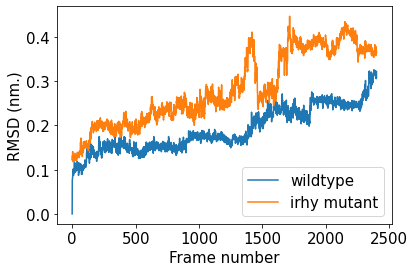

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 15}) #This sets a better default label size for plots

# Create labels for the two datasets:
datanames = ['wildtype', 'irhy mutant']

# define the plotting function:
def plot_rmsd(traj, datanames):
    """
    This function takes a MDTraj trajectory and a list of data names and produces an rmsd plot.
    
    """
    traj.superpose(traj[0]) # least squares fits each snapshot to the first.
    frames_per_set = len(traj) // len(datanames) # we assume each trajectory file is the same length.
    for i in range(len(datanames)):
        # The next two lines do the rmsd calculation:
        diff = traj.xyz[i * frames_per_set : (i + 1) * frames_per_set] - traj.xyz[0]
        rmsd = np.sqrt((diff * diff).sum(axis=2).mean(axis=1))
        plt.plot(rmsd, label=datanames[i]) # plot the line for this dataset on the graph.
    plt.xlabel('Frame number')
    plt.ylabel('RMSD (nm.)')
    plt.legend(loc='lower right')

# now use the plotting function:    
plot_rmsd(trajdata, datanames)

#### What do you conclude from these graphs? Do the simulations look well-equilibrated?

Let's calculate the root-mean-square fluctuations (RMSFs) of the atoms in each trajectory. This will tell us which parts of the structure are most mobile, and which are most rigid. The most flexible parts of the system are likely to be those most difficult to equilibrate and to sample well.

Text(0.5, 1.0, 'irhy mutant')

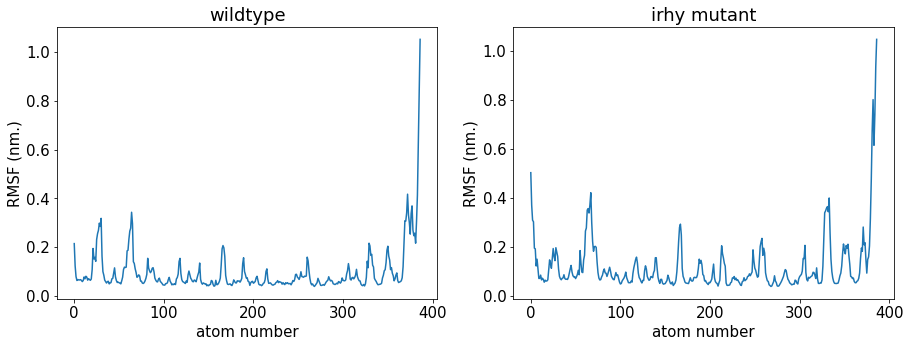

In [3]:
def plot_rmsf(traj):
    """
    Plots the root mean square fluctuations of the atoms in a MDTraj trajectory.
    
    """
    diff = traj.xyz - traj.xyz.mean(axis=0)
    rmsf = np.sqrt((diff * diff).sum(axis=2).mean(axis=0))
    plt.xlabel('atom number')
    plt.ylabel('RMSF (nm.)')
    plt.plot(rmsf)
    
plt.figure(figsize=(15,5))
plt.subplot(121)
frames_per_set = len(trajdata) // len(datanames)
plot_rmsf(trajdata[:frames_per_set]) # the first half of the cofasu has the wt data.
plt.title(datanames[0])
plt.subplot(122)
plot_rmsf(trajdata[frames_per_set:]) # the second half of the cofasu has the irhy data.
plt.title(datanames[1])

The left-hand plot is for the wild-type trajectory, the right-hand one is for the irhy mutant. It's clear that in both cases the C-terminus of the protein is exceptionally dynamic, and probably the least well-sampled. Since this region is well away from the oseltamivir binding site, let's repeat the RMSD analysis, leaving residues 370 onwards out:

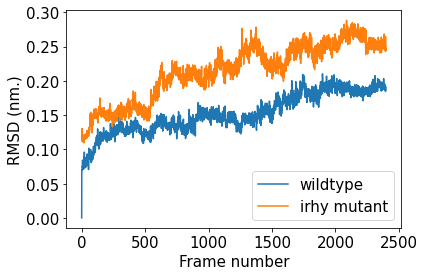

In [4]:
# Create an MDTraj trajectory for just a selection of the atoms in the system:
selection = trajdata.topology.select('resid 1 to 370')
seldata = mdt.Trajectory(trajdata.xyz[:, selection], trajdata.topology.subset(selection))

plot_rmsd(seldata, datanames)

Are the results as you expect? If you discount the particularly flexible C-terminus of the protein, do these simulations otherwise look well equilibrated?

**_EXERCISE_**:

**The RMSF plot shows that there are also quite dynamic regions towards the N-terminus of the protein. What happens if you leave these out of the RMSD analysis too? Try editing the cell above so the selection is `resid 100 to 300` and repeat the analysis. Experiment with different selections.**

### Part 1B: PCA Analysis
Now let's move from analysis by RMSD to analysis by PCA.

The code below does a PCA analysis on both trajectory sets combined, and then plots the projection of each trajectory onto the common PC1/PC2 subspace:

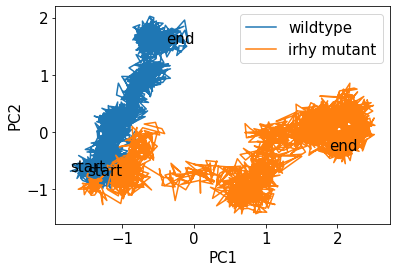

In [5]:
from mdplus import pca
# First define a plotting function:
def plot_pca(scores, datanames, highlight=None):
    """
    Plots the projection of each trajectory in the cofasu in the PC1/PC2 subspace.
    
    If highlight is a number, this dataset is plotted in red against all others in grey.
    
    """
    p1 = scores[:,0] # the projection of each snapshot along the first principal component
    p2 = scores[:,1] # the projection along the second.

    frames_per_rep = len(p1) // len(datanames) # number of frames (snapshots) in each dataset - assumed equal length
    for i in range(len(datanames)):
        start = i * frames_per_rep
        end = (i + 1) * frames_per_rep
        if highlight is None: # each dataset is plotted with a different colour
            plt.plot(p1[start:end], p2[start:end], label=datanames[i]) 
            plt.text(p1[start], p2[start], 'start')
            plt.text(p1[end-1], p2[end-1], 'end')
        else:
            if i != highlight:
                plt.plot(p1[start:end], p2[start:end], color='grey')
    if highlight is not None:
        start = highlight * frames_per_rep
        end = (highlight + 1) * frames_per_rep
        plt.plot(p1[start:end], p2[start:end], color='red', label=datanames[highlight])
        plt.text(p1[start], p2[start], 'start')
        plt.text(p1[end-1], p2[end-1], 'end')

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()

# Now use it:
selection = trajdata.topology.select('resid 1 to 370')
seldata = trajdata.atom_slice(selection)
p = pca.PCA()
scores = p.fit_transform(seldata.xyz)
plot_pca(scores, datanames)

The left-hand plot shows the track in PC1/PC2 space of each trajectory. Both start in the bottom right hand corner but then move off in separate directions.


**_EXERCISE_**:

**As you did for the RMSD analysis, experiment with leaving out the most dynamic (N- and C-terminal) regions of the proteins from the PCA analysis, by editing the atom selections.**

#### Compare the RMSD and PCA plots. Consider how clearly they identify the similarities and differences between the two trajectories, and illustrate sampling and convergence.

[Next: Part 2: Analysis of replicate simulations of dynein light chain](.PCA_analysis_of_MD_simulations-2.ipynb)